In [1]:
import gym

class ActionSamplingEnvironment:
    def __init__(self, env: gym.Env):
        self._env = env

    @property
    def metadata(self):
        return self._env.metadata
    
    @property
    def reward_range(self):
        return self._env.reward_range
    
    @property
    def spec(self):
        return self._env.spec

    @property
    def action_space(self):
        return self._env.action_space

    @property
    def observation_space(self):
        return self._env.observation_space

    def step_dist(self, action_dist):
        """Run one timestep of the environment's dynamics. When end of
        episode is reached, you are responsible for calling `reset()`
        to reset this environment's state.

        Accepts an action and returns a tuple (observation, reward, done, info).

        Args:
            action_dist (object): a distribution over actions, provided by the agent

        Returns:
            action (object): an action sampled from the provided distribution
            observation (object): agent's observation of the current environment
            reward (float) : amount of reward returned after previous action
            done (bool): whether the episode has ended, in which case further step() calls will return undefined results
            info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
        """
        action = action_dist.sample()
        next_obs, reward, done, info = self._env.step(action.numpy())
        return action, next_obs, reward, done, info

    def reset(self):
        """Resets the state of the environment and returns an initial observation.

        Returns:
            observation (object): the initial observation.
        """
        return self._env.reset()

    def render(self, mode='human'):
        self._env.render(mode=mode)

    def close(self):
        """Override close in your subclass to perform any necessary cleanup.

        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        self._env.close()

    def seed(self, seed=None):
        """Sets the seed for this env's random number generator(s).

        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.

        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        return self._env.seed(seed=seed)

    @property
    def unwrapped(self):
        """Completely unwrap this env.

        Returns:
            gym.Env: The base non-wrapped gym.Env instance
        """
        return self._env.unwrapped

    def __str__(self):
        return self._env.__str__()

    def __enter__(self):
        """Support with-statement for the environment. """
        return self._env.__enter__()

    def __exit__(self, *args):
        """Support with-statement for the environment. """
        return self._env.__exit__(*args)

In [2]:
import numpy as np
from tqdm import tqdm
import h5py

class EnvironmentRecorder(ActionSamplingEnvironment):
    def __init__(self, env: gym.Env):
        super().__init__(env)
        self.reset_buffer()
    
    def reset(self):
        self._obs = self._env.reset()
        self._step_count = 0
        return self._obs
    
    def step_dist(self, action_dist):
        _obs = self._obs
        action, next_obs, reward, done, info = super().step_dist(action_dist)
        info = {**info, 't': self._step_count}
        self.append_buffer((_obs, action, reward, next_obs, done, action_dist, info))
        self._obs = next_obs
        self._step_count += 1
        return action, next_obs, reward, done, info
    
    def reset_buffer(self):
        self._buffer = {
            'observations': [],
            'actions': [],
            'rewards': [],
            'next_observations': [],
            'terminals': [],
            'infos/action_probs': [],
            'infos/steps': [],
       }

    def append_buffer(self, tup):
        S, A, R, S_, done, action_dist, info = tup
        self._buffer['observations'].append(S)
        self._buffer['actions'].append(A)
        self._buffer['rewards'].append(R)
        self._buffer['next_observations'].append(S_)
        self._buffer['terminals'].append(done)
        self._buffer['infos/action_probs'].append(np.array(action_dist.probs))
        self._buffer['infos/steps'].append(info['t'])

    def npify(self, buffer):
        buffer_np = {}
        for k in buffer:
            if k == 'terminals':
                dtype = np.bool_
            if k == 'actions' or k == 'infos/steps':
                dtype = int
            else:
                dtype = np.float32

            buffer_np[k] = np.array(buffer[k], dtype=dtype)
        return buffer_np
    
    def save(self, save_path):
        dataset = h5py.File(save_path, 'w')
        buffer_np = self.npify(self._buffer)
        buffer_np['actions'] = buffer_np['actions'].astype(int)
        for k in buffer_np:
            dataset.create_dataset(k, data=buffer_np[k], compression='gzip')

In [3]:
from offsim4rl.agents.spinup import ppo_revealed
import gym
import random
import numpy as np
import torch

No protocol specified


In [4]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [5]:
env = EnvironmentRecorder(gym.make('CartPole-v1'))
env.seed(0)

[0]

In [6]:
ppo_revealed(
    env_fn=lambda: env, steps_per_epoch=1000, epochs=100, seed=0, 
    logger_kwargs=dict(output_dir='outputs/ppo', exp_name='CartPole-v1_ppo'),
    ac_kwargs=dict(hidden_sizes=[32,32], activation=torch.nn.ReLU), 
)

Logging data to outputs/ppo/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "actor_critic":	"MLPActorCritic_Revealed",
    "clip_ratio":	0.2,
    "env_fn":	"<function <lambda> at 0x7f1e240878c0>",
    "epochs":	100,
    "exp_name":	"CartPole-v1_ppo",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f1e01918590>":	{
            "epoch_dict":	{},
            "exp_name":	"CartPole-v1_ppo",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"outputs/ppo",
            "output_file":	{
                "<_io.TextIOWrapper name='outputs/ppo/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_kwargs":	{
        "exp_name":	"CartPole-v1_ppo",
        "output_dir":	"outputs/ppo"

In [19]:
env.save('outputs/CartPole-v1_ppo.h5')

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('outputs/ppo/progress.txt', sep='\t')

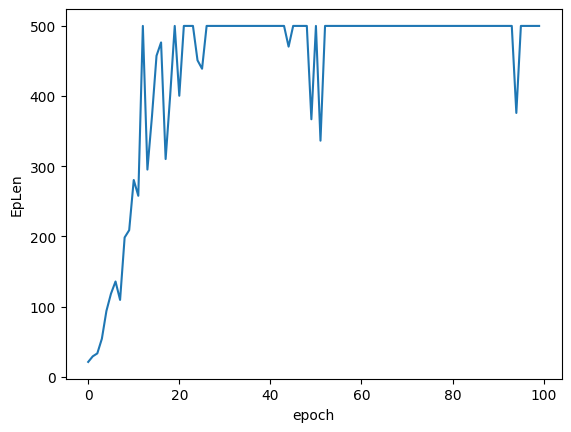

In [10]:
plt.plot(df['EpLen'])
plt.xlabel('epoch')
plt.ylabel('EpLen')
# plt.xlim(0,50)
plt.show()

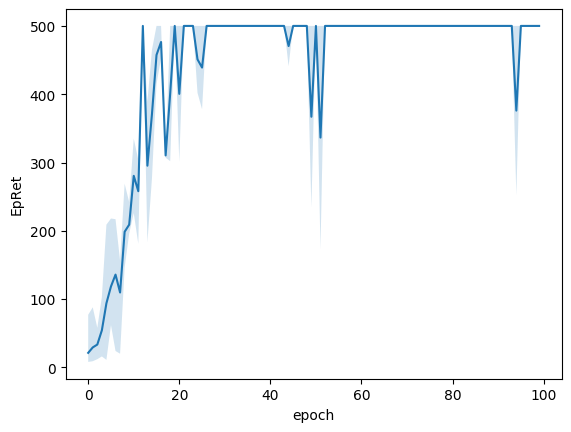

In [11]:
plt.plot(df['AverageEpRet'])
plt.fill_between(df['Epoch'], df['MinEpRet'], df['MaxEpRet'], alpha=0.2)
plt.xlabel('epoch')
plt.ylabel('EpRet')
plt.show()

In [12]:
def get_keys(h5file):
    keys = []

    def visitor(name, item):
        if isinstance(item, h5py.Dataset):
            keys.append(name)

    h5file.visititems(visitor)
    return keys

In [20]:
h5path = 'outputs/CartPole-v1_ppo.h5'
dataset = {}
with h5py.File(h5path, 'r') as dataset_file:
    for k in tqdm(get_keys(dataset_file), desc="load datafile"):
        try:  # first try loading as an array
            dataset[k] = dataset_file[k][:]
        except ValueError as e:  # try loading as a scalar
            dataset[k] = dataset_file[k][()]

load datafile: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 210.96it/s]


In [21]:
dataset.keys()

dict_keys(['actions', 'infos/action_probs', 'infos/steps', 'next_observations', 'observations', 'rewards', 'terminals'])

In [22]:
dataset['observations'].shape

(100000, 4)

In [23]:
i = 0
(
    dataset['observations'][i], 
    dataset['actions'][i], 
    dataset['rewards'][i], 
    dataset['next_observations'][i], 
    dataset['terminals'][i], 
    dataset['infos/action_probs'][i], 
    dataset['infos/steps'][i], 
)

(array([-0.04456399,  0.04653909,  0.01326909, -0.02099827], dtype=float32),
 1,
 1.0,
 array([-0.04363321,  0.24146827,  0.01284913, -0.3094653 ], dtype=float32),
 0.0,
 array([0.41804048, 0.58195955], dtype=float32),
 0)

[GCRAZGDL2222:170512] tcp_peer_recv_connect_ack: invalid header type: 68
[GCRAZGDL2222:170512] tcp_peer_recv_connect_ack: invalid header type: 42
[GCRAZGDL2222:170512] tcp_peer_recv_connect_ack: invalid header type: 5
[GCRAZGDL2222:170512] tcp_peer_recv_connect_ack: invalid header type: 214
[GCRAZGDL2222:170512] tcp_peer_recv_connect_ack: invalid header type: 79
[GCRAZGDL2222:170512] tcp_peer_recv_connect_ack: invalid header type: 78
[GCRAZGDL2222:170512] tcp_peer_recv_connect_ack: invalid header type: 205
[GCRAZGDL2222:170512] tcp_peer_recv_connect_ack: invalid header type: 238
[GCRAZGDL2222:170512] tcp_peer_recv_connect_ack: invalid header type: 87
[GCRAZGDL2222:170512] tcp_peer_recv_connect_ack: invalid header type: 117
[GCRAZGDL2222:170512] tcp_peer_recv_connect_ack: invalid header type: 108
[GCRAZGDL2222:170512] tcp_peer_recv_connect_ack: invalid header type: 255
Bad pipe message: %s [b"\xf1\xb9\xadN\xbf\x0fU\xeb\xec\x16\xfd\xf2N\x8bK\xe8\xbb\x13 tm(F~7\xccH'\x83\xe9\xf1+\xac\xec\

In [17]:
import matplotlib.pyplot as plt

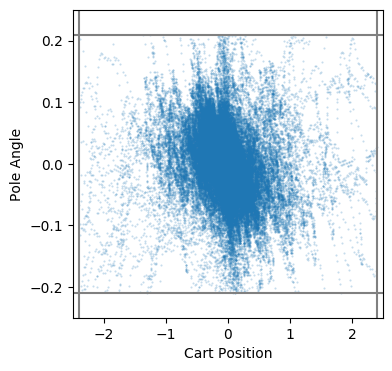

In [18]:
fig, ax = plt.subplots(figsize=(4,4))
plt.plot(dataset['observations'][:,0], dataset['observations'][:,2], alpha=0.25, lw=0, marker='.', mew=0, markersize=3)
plt.xlim(-2.5, 2.5)
plt.ylim(-0.25, 0.25)
plt.axhline(-0.2095, c='gray')
plt.axhline(0.2095, c='gray')
plt.axvline(-2.4, c='gray')
plt.axvline(2.4, c='gray')
plt.xlabel('Cart Position')
plt.ylabel('Pole Angle')
# plt.savefig(f'data/{env_name}-state_visitation.pdf')
plt.show()